<a href="https://colab.research.google.com/github/QuentinGib/WebNews_TopicExtraction/blob/main/NewsClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **Clustering et extraction du sujet d'un article** - par Quentin Gibon

---


## Introduction
L'objectif de ce projet est de retrouver le sujet d'un article de presse par clustering (et non pas par classification). Nous allons pour cela utiliser un dataset d'articles de presses françaises (trouvé [ici](https://webhose.io/free-datasets/french-news-articles/)) pour enrichir notre model, et nous tenterons d'extraire le sujet d'un article scrappé sur le site du journal [Le Monde](https://www.lemonde.fr/).

Le domaine dans lequel se place cette étude se nomme le Traitement Automatique du Langage naturel (TAL) ou Natural Language Processing (NLP) en anglais. C'est un des domaines de recherche les plus actifs en science des données actuellement, à l’intersection du Machine Learning et de la linguistique. Il a pour but d’extraire des informations et une signification d’un contenu textuel.

Comme mentionné précédemment, ici nous ne connaissons pas les sujets des articles que traite le model. L'objectif est de former des clusters, de regrouper les articles présentant des similarités pour en extraire le sujet.

Dans ce notebook seront exposés deux algorithmes : le LDA (Latent Dirichlet Allocation) et un autre "maison" de Topic Modeling en utilisant BERT.

Ce notebook vient en complément d'un autre projet autour du NLP ([voir le projet](https://github.com/QuentinGib/WebNews_Summary)).

## Bibliothèques et modules
Dans un premier temps nous avons besoin d’installer toutes les bibliothèques et autres modules qui nous serviront pour réaliser le projet. J'ai divisé les éléments en deux, ceux utilisés par le premier algorithme (BERTopic) et ceux par le LDA.

**BERTopic** : Comme le nom l'indique, nous allons utiliser les models BERT pour créer l'embedding et tokenizer les phrases des articles, particulièrement nous utiliserons `sentence-transformers`, un model d'embedding qui fonctionne bien avec un grand nombre de documents. BERT rentre dans la catégorie des `transformers`, ce sont des modèles état-de-l’art qui apprennent des représentations vectorielles à partir d’un texte d’entrée et qui dépassent les capacités humaines sur certains points. Ces modèles peuvent être pré-entraînés et sont mis à disposition par Hugging Face, une startup spécialisée dans le traitement de langage naturel.

Pour la reduction de dimensionalité, on choisit l'algorithme UMAP, adapté à notre projet car "il conserve une partie importante de la structure locale de haute dimension dans une dimensionnalité inférieure".

Enfin nous le verrons, l'algorithme de clusterisation que l'on choisit est HDBSCAN car il fonctionne bien avec UMAP et propose l'avantage de ne pas forcer tous les points à rentrer dans un cluster, les considérants comme des outliers.

In [ ]:
!pip install sentence-transformers
!pip install umap-learn
!pip install hdbscan

En ce qui concerne le **LDA** :

La plupart des bibliothèques que l'on utilise servent au pre-processing des données. Nous n'en avions pas besoin pour **BERTopic** car BERT est suffisamment sophistiqué pour analyser le sens de toutes les nuances du langage et ne nécessite pas de recourir aux étapes de pre-processing telles que la suppression des stop words, le stemming et les transformations en minuscules.

D'abord, nous utiliserons `SpaCy`. SpaCy est une jeune librairie (2015) qui offre des modèles pré-entraînés pour diverses applications, y compris la reconnaissance d’entités nommées. SpaCy est la principale alternative à `NLTK` (Natural Language Tool Kit), la librairie historique pour le TAL avec Python que nous utiliserons également car elle possède certains outils que SpaCy n'a pas. Parmis ces outils, on retrouve les `stop words`, mots fréquents et portants peu d'information, ou un stemmer `Snowball Stemmer`.

Un exemple de modèle SpaCy que nous chargeons est `fr_core_news_sm`, un réseau convolutionnel entraîné sur deux corpus, WikiNER et Sequoia, ce qui représente de gros volumes de données en français (typiquement plusieurs dizaines de Go).

Enfin `numpy` et `pandas` seront utiles pour quelques manipulations de données.

In [ ]:
!python -m spacy download fr_core_news_sm
!pip install spacy
import spacy
import fr_core_news_sm
import nltk
nltk.download("punkt")
from nltk.corpus import stopwords
nltk.download("stopwords")
from nltk.stem.snowball import SnowballStemmer
import numpy as np
import pandas as pd

## Chargement des données

Nous allons d'abord scrapper un article sur Le Monde. Pour l'exemple j'ai choisi un article de sport, mais la technique que j'ai implémenté permet de scrapper n'importe quel article du journal en lui fournissant simplement l'URL. L'article est par la suite stocké dans un dictionnaire ayant cette architecture : 

```
mainArticle = 
{
  "title": "Le titre de l'article",
  "link": "Le lien pour acceder à l'article",
  "subTitle": "Le sous titre de l'article",
  "content": ["paragraphe 1", "paragraphe 2", ...]
}
```

In [ ]:
import requests
from bs4 import BeautifulSoup

requete = requests.get("https://www.lemonde.fr/")
page = requete.content
soupAccueil = BeautifulSoup(page)

#Récupère article sur un lien
lien = input("URL de l'article LeMonde.fr : ")
requete = requests.get(lien)
page = requete.content
soupAccueil = BeautifulSoup(page)

mainArticle = {
    "title": soupAccueil.find("h1", {"class": "article__title"}).get_text().replace(u'\xa0', u' '),
    "link": lien
}

requete = requests.get(mainArticle["link"])
page = requete.content
soupMainArticle = BeautifulSoup(page)
mainArticle["subTitle"] = soupMainArticle.find("p", {"class": "article__desc"}).get_text().replace(u'\xa0', u' ')
paragraphes = soupMainArticle.find_all("p", {"class": "article__paragraph"})
mainArticle["content"] = list(map(lambda para: para.get_text().replace(u'\xa0', u' '), paragraphes))
print(mainArticle)

URL de l'article LeMonde.fr : https://www.lemonde.fr/sport/article/2021/04/03/ligue-1-lille-souligne-les-manques-du-psg-et-reprend-la-tete-du-championnat_6075498_3242.html
{'title': 'Ligue 1 : Lille souligne les manques du PSG et reprend la tête du championnat', 'link': 'https://www.lemonde.fr/sport/article/2021/04/03/ligue-1-lille-souligne-les-manques-du-psg-et-reprend-la-tete-du-championnat_6075498_3242.html', 'subTitle': '    Les Lillois se sont imposés (1-0) samedi 3 avril à Paris. Rien de rassurant pour les Parisiens, à quatre jours du quart de finale de la Ligue des champions contre le Bayern Munich. ', 'content': ['Le trône national des Parisiens était donc fragile. Revenu en tête de la Ligue 1 juste avant la trêve internationale à la faveur d’un succès contre Lyon (4-2), le 21 mars, le PSG l’a immédiatement reperdu, sans gloire, dans le choc face à Lille, samedi 3 avril. Avant le match de Ligue des champions contre le Bayern Munich, la prestation des hommes de Mauricio Pochetti

Enfin j'ai sélectionné les 800 premiers fichiers json de mon dataset d'articles de presse française pour les charger dans un dataframe pandas `temp` (attention : j'utilise glob pour naviguer dans les fichiers de mon google colab, à adapter selon l'endroit où vous executez le code). Le contenu des ces articles est accessible dans `temp.text`.

In [ ]:
import os, json
import glob
pd.set_option('display.max_columns', None)

temp = pd.DataFrame()

file_list = glob.glob('*.json')

dfs = [] # an empty list to store the data frames
for file in file_list:
    data = pd.read_json(file, lines=True) # read data frame from json file
    dfs.append(data) # append the data frame to the list

temp = pd.concat(dfs, ignore_index=True) # concatenate all the data frames in the list.

In [ ]:
temp.text

0      3/10/16 - 07h59 Source: AFP © photo news. Le p...
1      Pouvez-vous nous indiquer l'article de loi? Il...
2      En magasin Manette Xbox One Elite + Adaptateur...
3      Veste bombers rouge bordeaux taille M neuve Ty...
4                                                       
                             ...                        
795    Aujourd'hui 09h14 - Céline FION - L'Avenir C’e...
796    AFP Agression de Kim Kardashian : pourquoi cet...
797    Travail dissimulé: 12 interpellés, 1,4M€ amass...
798    Une semaine en Europe 1 - L'hommage à Shimon P...
799    > Faits divers | 02 octobre 2016, 8h19 | \n77 ...
Name: text, Length: 800, dtype: object

Nous aurons l'occasion d'en reparler, mais j'ai fini par remarquer que le dataset était d'extrême mauvaise qualité. Beaucoup d'articles se répètent, certains sont vides, et d'autres ne sont même pas des articles mais des annonces LeBonCoin, pubs, commentaires et discussions de forum.

<br>

---



## BERTopic

Tout d'abord, on charge le model adapté à nos données pour trouver l'embedding des documents. Sentence Transformer ne possède pas de modèle spécialisé en français, c'est pourqoi nous utilisons `paraphrase-xlm-r-multilingual-v1`. Il existe un model BERT pour le français (CamemBERT), non compatible avec sentence transformer mais que l'on pourrait utiliser pour calculer l'embedding aussi, néanmoins après quelques tests il apparaît que cela prend beaucoup trop de temps pour la quantité de données que l'on utilise, et je pense que les résultats ne seraient que très sensiblement différents.

On calcule donc l'embedding de notre dataset d'articles, c'est un peu long (~ 5 min).

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-xlm-r-multilingual-v1')
embeddings = model.encode(temp.text, show_progress_bar=True)

Puis on calcule l'embedding de l'article Le Monde avant de concaténer le résultat avec les embeddings du dataset. J'ai choisi de séparer ces deux opérations pour gagner du temps et ne pas avoir à tout recalculer lorsque l'on ajoute un article Le Monde.

In [ ]:
text = " ".join(mainArticle["content"])
plusEmbedding = model.encode(text, show_progress_bar=True)
embeddings = np.concatenate((embeddings, [plusEmbedding]))

On rentre dans le vif du sujet. Comme annoncé on réduit d'abord la dimensionalité des données avec UMAP à 4, en gardant le nombre de voisins locaux à 5. Ces paramètres peuvent être modifiés pour optimiser l'algorithme de clustering, mais en testant des combinaisons diffèrentes, ces paramètres semblent offrir les meilleurs résultats dans notre cas.

Puis on cherche les cluster avec HDBSCAN. HDBSCAN est un algorithme dit "basé sur la densité", et fonctionne donc bien avec UMAP qui garde une structure locale.

Pour visualiser les résultats, on réduit la dimensionalité des données à 2 pour pouvoir les afficher sur un graph. On obtient donc un graphique avec tous les points représentant les articles, colorisés selon leur appartenance à un cluster. Les points grisés représentent les articles que HDBSCAN a considéré comme outliers. Nous pouvons voir que même dans un espace à 2 dimensions, une certaine structure locale est conservée, excepté pour quelques clusters.

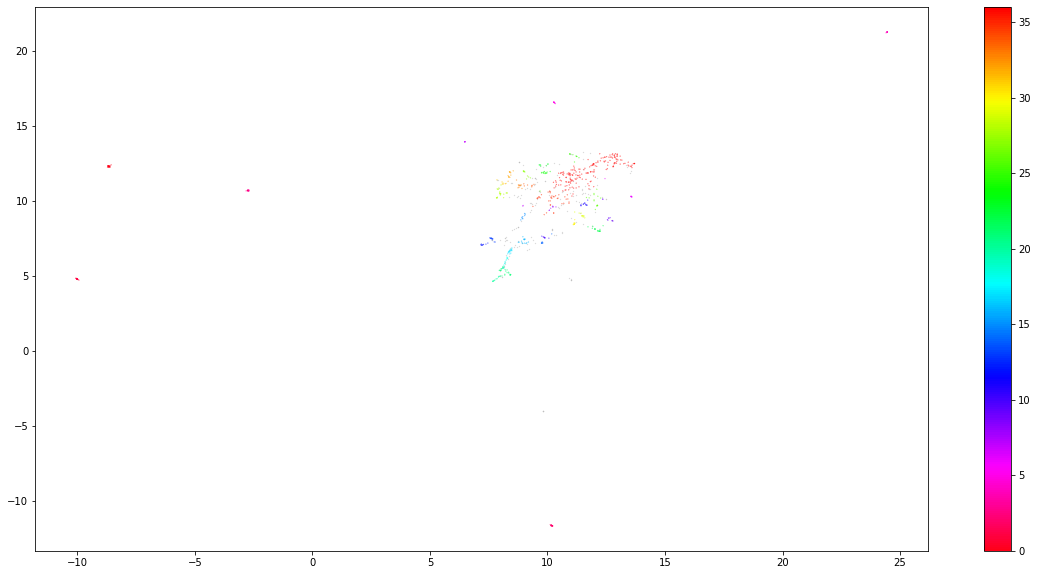

In [ ]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=5, 
                            n_components=4, 
                            metric='cosine').fit_transform(embeddings)

import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=5,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=5, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

Les clusters sont calculés, maintenant qu'en est-il de leurs représentations ? Sans connaitre les sujets des articles, nous allons chercher à les retrouver pour chaque cluster créé. Pour ceci nous allons regrouper les articles contenus dans un cluster comme s'ils formaient un unique grand article, et appliquer une méthode de pondération sur les mots pour en extraire les plus importants, les plus représentatifs du cluster. Nous utilisons la méthode TF-IDF, souvent utilisée en recherche d'information et en particulier dans la fouille de textes. Parfaitement adaptée donc.

Mathématiquement parlant, nous allons extraire la fréquence de chaque mot `t` pour chaque cluster `i` et divisée par le nombre total de mots `w`. Cette action peut être vue comme une forme de régularisation des mots fréquents en cluster. Ensuite, le nombre total, non joint, de documents `m` est divisé par la fréquence totale du mot `t` dans toutes les clusters `n`. Voir la formule ci-dessous.

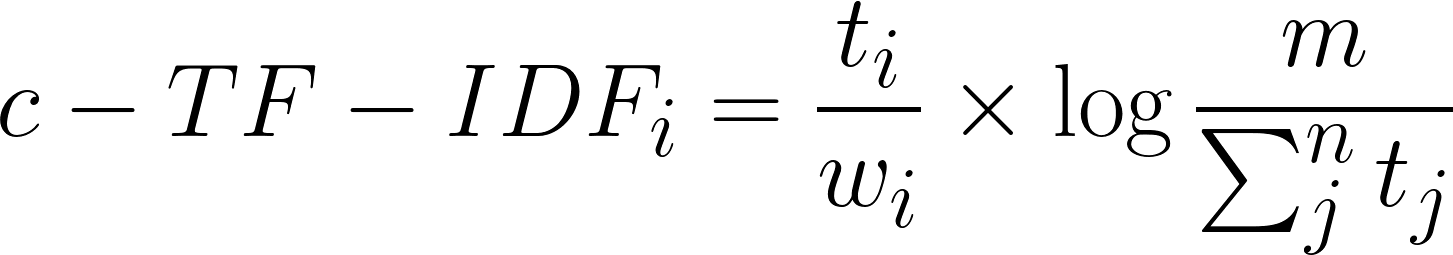

In [ ]:
data = temp.text.to_numpy()
data = np.concatenate((data, [text]))
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df)
topic_sizes.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


,Topic,Size
37,36,179
0,-1,160
36,35,38
1,0,25
22,21,24
29,28,22
2,1,21
3,2,21
4,3,18
23,22,17


On obtient ainsi un tableau `topic_sizes` contenant le nombre d'articles dans chaque sujet, dans chaque cluster donc. On remarque que de nombreux articles sont contenus dans le sujet -1, correspondant aux outliers, les points grisés sur le graphique.

`top_n_words[numéro du sujet][:10]` nous permet d'afficher les 10 mots les plus importants, les plus représentatifs du cluster, et donc d'en extraire son sujet !



In [ ]:
top_n_words[35][:10]

[('hergé', 0.004103217413034801),
 ('art', 0.0038255150214291196),
 ('charrues', 0.0038037383317870415),
 ('poète', 0.003735334210940806),
 ('carhaix', 0.0035793419175918994),
 ('tintin', 0.0035111430754957308),
 ('vieilles', 0.0035111430754957308),
 ('adoption', 0.0034534568008183003),
 ('poésie', 0.0033490217563880913),
 ('cépages', 0.0033490217563880913)]

In [ ]:
docs_df

,Doc,Topic,Doc_ID
0,3/10/16 - 07h59 Source: AFP © photo news. Le p...,23,0
1,Pouvez-vous nous indiquer l'article de loi? Il...,1,1
2,En magasin Manette Xbox One Elite + Adaptateur...,13,2
3,Veste bombers rouge bordeaux taille M neuve Ty...,-1,3
4,,0,4
...,...,...,...
796,AFP Agression de Kim Kardashian : pourquoi cet...,6,796
797,"Travail dissimulé: 12 interpellés, 1,4M€ amass...",36,797
798,Une semaine en Europe 1 - L'hommage à Shimon P...,36,798
799,"> Faits divers | 02 octobre 2016, 8h19 | \n77 ...",29,799


`docs_df` contient l'ensembles des textes et leur sujet associé. On retrouve notre article Le Monde en 800eme position, associé au cluster 36. Voyons voir ce qu'il en ressort :

In [ ]:
top_n_words[36][:10]

[('match', 0.004462481154849431),
 ('ligue', 0.003379057201397656),
 ('équipe', 0.0026967322377630574),
 ('face', 0.0026504132195897616),
 ('club', 0.0026376118795554925),
 ('jeu', 0.002560321182838733),
 ('joueur', 0.002335444831228248),
 ('minutes', 0.0023133928535333547),
 ('tête', 0.002309771011268974),
 ('journée', 0.0022486606029753354)]

Pour un article sur le football, c'est pas trop mal ! En regardant l'article juste au dessus par exemple, commençant par "faits divers" et associé au sujet 29, on a :

In [ ]:
top_n_words[29][:10]

[('icann', 0.024608107792783048),
 ('accident', 0.02234197775963479),
 ('internet', 0.015537149002602427),
 ('véhicule', 0.015053765082271211),
 ('blessé', 0.014157639331234333),
 ('carman', 0.013488566314672405),
 ('mère', 0.012059797595415431),
 ('grièvement', 0.01124047192889367),
 ('nathan', 0.01124047192889367),
 ('morts', 0.009887276638019726)]

Pas joyeux, mais ça colle. D'autres sujets trouvés qui paraissent clairs :

In [ ]:
top_n_words[28][:10]

[('migrants', 0.011778010264179028),
 ('calais', 0.010554246544347654),
 ('farc', 0.008784991431353967),
 ('référendum', 0.007690201778108856),
 ('mur', 0.0076253338464812885),
 ('préfecture', 0.007420311220277995),
 ('arrêté', 0.00642926524325589),
 ('répartition', 0.0062160971313259435),
 ('port', 0.005676919799504691),
 ('orban', 0.005646443947957472)]

In [ ]:
top_n_words[22][:10]

[('alep', 0.016172808143555754),
 ('syrie', 0.013772684257164273),
 ('al', 0.012205935771589177),
 ('rebelles', 0.00954841804146929),
 ('humanitaire', 0.00883220923570289),
 ('bombardements', 0.007850852653958124),
 ('régime', 0.007833989784586746),
 ('ville', 0.007717960043655831),
 ('hôpital', 0.007601606661880051),
 ('kerry', 0.00743019680581553)]

In [ ]:
top_n_words[15][:10]

[('smart', 0.0235307410344361),
 ('fortwo', 0.01882950090550192),
 ('électrique', 0.0172828755247756),
 ('ed', 0.016237685254725055),
 ('carrosseries', 0.01572984945112382),
 ('km', 0.014395878655218165),
 ('gamme', 0.012738332911552625),
 ('nm', 0.0125070455656508),
 ('moteur', 0.01236157232045568),
 ('nouvelles', 0.01234597114110451)]



---

## LDA (Latent Dirichlet Allocation)

Cette méthode est la plus classique. Le LDA est un modèle génératif probabiliste permettant d’expliquer des ensembles d’observations, par le moyen de groupes non observés, eux-mêmes définis par des similarités de données.

Ou plus simplement, c'est un modèle d'apprentissage automatique non supervisé qui prend des documents en entrée et trouve des sujets en sortie. Le modèle indique également dans quel pourcentage chaque document parle de chaque sujet. Vous l'aurez compris, notre méthode BERTopic se base également sur ce principe.

La première étape concerne le pré-processing de nos données, de notre dataset en l'occurrence. Contrairement à BERT, nous avons besoin de réaliser toutes les opérations de stop words, de ponctutation removal etc car nous utilisons le tokenizer NLTK (par phrases) et nlp de SpaCy (par mots).

Ce code de data pre-processing est tiré de [ce notebook](https://github.com/QuentinGib/WebNews_Summary). Vous y trouverez également des explications à ce sujet.



In [ ]:
#tokeniser les mots
def return_token(sentence, nlp):
    # Tokeniser la phrase
    doc = nlp(sentence)
    # Retourner le texte de chaque token
    return [X.text for X in doc]

# MAIN
stop_words = stopwords.words('french')
nlp = fr_core_news_sm.load()
tokenizer = nltk.data.load('tokenizers/punkt/PY3/french.pickle')
data = []
i=0
for articles in temp.text:
    # Step 1 - Read text and tokenize
    phrases = tokenizer.tokenize(articles)
    
    if phrases == []:
        continue

    # Preprocessing
    # Filtre les stop words
    clean_sentences = []
    order = []
    idx = 0
    for sentence in phrases:
      clean_words = []
      order.append(idx)
      idx += 1
      for token in return_token(sentence, nlp):
        if token not in stop_words:
            mot = ''.join(e for e in token if e.isalnum())
            if mot != '' and len(mot) > 2:
                clean_words.append(mot)
    i+=1
    print(i)
    data.append(clean_words)

A l'issue de cette opération, on obtient un tableau `data` contenenant tous les articles du dataset tokénisés par mot.

On envoie le tout dans le model de LDA fourni par gensim, avec ces paramètres :

1.   le nombre de sujet est égal à `num_topics`.
2.   la distribution du nombre de mots par sujet est gérée par `eta`.
3.   la distribution du nombre de sujets par document est gérée par `alpha`.


In [ ]:
from gensim import corpora, models

list_of_list_of_tokens = data
# ["a","b","c"] are the tokens of document 1, ["d","e","f"] are the tokens of document 2...
dictionary_LDA = corpora.Dictionary(list_of_list_of_tokens)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(list_of_tokens) for list_of_tokens in list_of_list_of_tokens]

num_topics = 20
%time lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  passes=4, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))

On peut ainsi afficher les sujets trouvés :

In [ ]:
for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=10):
    print(str(i)+": "+ topic)
    print()

0: 0.102*"Lire" + 0.094*"aussi" + 0.039*"suite" + 0.031*"français" + 0.028*"photo" + 0.026*"toutes" + 0.022*"2016" + 0.022*"article" + 0.021*"October" + 0.020*"ici"

1: 0.101*"Envoyer" + 0.086*"Les" + 0.072*"être" + 0.068*"aussi" + 0.065*"peut" + 0.065*"intéresser" + 0.064*"pourront" + 0.064*"suivantes" + 0.064*"annonces" + 0.030*"argent"

2: 0.034*"Union" + 0.033*"considérant" + 0.023*"européenne" + 0.021*"demande" + 0.020*"droits" + 0.016*"pays" + 0.016*"travailleurs" + 0.014*"européen" + 0.013*"Commission" + 0.013*"leurs"

3: 0.048*"lire" + 0.041*"article" + 0.034*"Parisien" + 0.033*"Les" + 0.031*"plus" + 0.024*"var" + 0.024*"podcasts" + 0.024*"sound" + 0.024*"exports" + 0.024*"reste"

4: 0.342*"AFP" + 0.111*"2016" + 0.050*"30092016" + 0.032*"01102016" + 0.025*"Paris" + 0.022*"France" + 0.021*"octobre" + 0.021*"passe" + 0.019*"Avec" + 0.016*"000"

5: 0.195*"Publicité" + 0.041*"leparisienfr" + 0.033*"Rebloguer" + 0.029*"Plus" + 0.025*"déjà" + 0.024*"cas" + 0.023*"Afrique" + 0.021*"Un

Ainsi que le sujet trouvé par document, et son pourcentage d'appartenance à ce sujet :

In [ ]:
lda_model[corpus[0]] # corpus[0] means the first document.

[(0, 0.9136363)]

Un grand avantage de cette librairy concerne les possibiltés de visualisation qu'elle offre avec `pyLDAvis`. Cela nous permet de comparer des sujets sur deux dimensions réduites et d'observer la répartition des mots dans les sujets.

In [ ]:
%matplotlib inline
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models

In [ ]:
vis = pyLDAvis.gensim_models.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:302: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  token_table['Freq'] = token_table['Freq'].round()


Ensuite on peut y associer notre article Le Monde, pour trouver à quels clusters il se rapproche. Toujours en appliquant le même data pre-processing, on visualise son appartenance aux clusters avec `lda_model[dictionary_LDA.doc2bow(article tokénisé)]`.

In [ ]:
new_text = " ".join(mainArticle["content"])
# Step 1 - Read text and tokenize
phrases = tokenizer.tokenize(new_text)

clean_sentences = []
order = []
idx = 0
for sentence in phrases:
  clean_words = []
  order.append(idx)
  idx += 1
  for token in return_token(sentence, nlp):
    if token not in stop_words:
        mot = ''.join(e for e in token if e.isalnum())
        if mot != '' and len(mot) > 2:
            clean_words.append(mot)

lda_model[dictionary_LDA.doc2bow(clean_words)]

[(6, 0.28551733), (11, 0.18504067), (16, 0.5109637)]

L'article parle à 51% du sujet 16, à 28% du sujet 6 et à 18% du sujet 11.

Sauf que vous l'aurez remarqué, les clusters trouvés ou du moins les mots constituants ces clusters n'ont aucun sens. L'erreur vient très certainement de moi, notamment de mon data pre processing puisqu'il semble que les stop words n'ont pas été correctement retirés. J'ai tenté des petites astuces qui ont donné de meilleurs résultats, en n'appliquant pas de stemmer (les mots étaient totalement dénaturés, mauvais pour la visualisation) et j'ai exclu tous les mots composés de 1 ou 2 lettres, mais cela n'a pas été suffisant.



---

## Analyse et conclusion

C'est indéniable, mon implémentation de BERTopic est la plus efficace. Dans ce type de projet, il est impossible de mettre un chiffre sur l'efficacité des algorithme, si ce n'est vérifier au cas par cas que les articles sont associés à un sujet cohérent. Les résultats n'en sont néanmoins que moyennement satisfaisant, beaucoup de sujets parmi ceux extraits n'ont quasiment aucun sens. Mais ce n'est pas forcément négatif.

Comme je l'ai expliqué précédemment, le dataset d'articles trouvé sur internet est très mauvais, et très peu représentatif de la diversité des sujets d'articles de presse. Mais la technique de clusterisation semble fonctionner. L'article de sport du site Le Monde appartient au bon cluster et les mots extraits sont justes. Certains des sujets n'ayant que peu de sens sont en réalité composés de mots appartenant à un lexique d'annonce LeBonCoin par exemple (envoyer, lettre, annonce, vendeur...).

Ce qui me laisse penser qu'avec un dataset plus cohérent, cet algorithme pourrait être très bon. Il faudrait par exemple le constituer "à la main" en scrappant un certain nombre d'url. C'est une piste d'amélioration car malheureusement, je manque de temps.

<br>
<br>


---

# Références


*   https://medium.com/@vitalshchutski/french-nlp-entamez-le-camembert-avec-les-librairies-fast-bert-et-transformers-14e65f84c148
*   https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6
*   https://towardsdatascience.com/the-complete-guide-for-topics-extraction-in-python-a6aaa6cedbbc
*   https://webhose.io/free-datasets/french-news-articles/
*   https://www.newseye.eu/blog/news/multilingual-dynamic-topic-modelling/
*   https://towardsdatascience.com/interactive-topic-modeling-with-bertopic-1ea55e7d73d8
*   https://github.com/MaartenGr/BERTopic/
*   https://www.lemonde.fr/

